In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Start with just importing the time domain module of simpeg, and a utility to plot a layered model.
import simpeg.electromagnetics.time_domain as tdem

from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
    inversion,
)

from simpeg.data_misfit import L2DataMisfit

import discretize
from discretize import TensorMesh

In [6]:
from function import (
    plot_sounding,
    get_sounding_df
)

### Load data from .csv

In [8]:
#please download data from "release" on the repository and rename the file_path below

file_path = "../../flight_line_101102_101201.csv"
file_path_all_data = "../../AusAEM_WA_Block_E_EM.csv"

df = pd.read_csv(file_path, 
                 delimiter=",") 

df_all = pd.read_csv(file_path_all_data, 
                 delimiter=",") 

# Replace invalid values (-99999999) with NaN
df.replace(-99999999, np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
# Drop rows with missing values
df.dropna(inplace=True)

/var/folders/nv/3rmg65wj733gdy4gk5sxm8cc0000gn/T/ipykernel_5283/1952385971.py:9: DtypeWarning: Columns (153,154,156,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(file_path_all_data,


In [9]:
df["GPS_Alt"].min()

18.94

### Select one souding

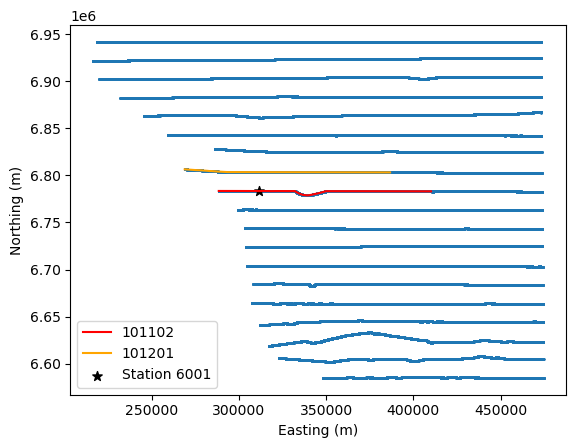

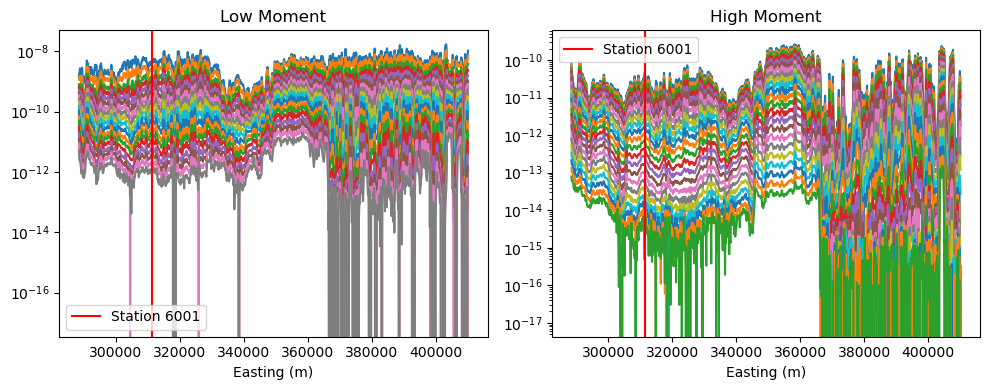

In [11]:
# input flight line number and sounding ID
# 101102 or 101201
flightline = 101102 # or 101201

# 0 - 7420 for flight line 101102 
# 7421 - 16261 for flight line 101201
sounding = 6001 #7300

plot_sounding(flightline, sounding, df, df_all)

station, station_lm_data, station_hm_data, station_lm_std, station_hm_std = get_sounding_df(flightline, sounding, df)

In [12]:
# load the gate opening time for LM and HM respectively
LM_excel = "../../LM_times.csv"
HM_excel = "../../HM_times.csv"
LM_times_csv = pd.read_csv(LM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_times_csv = pd.read_csv(HM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [13]:
# extract gate_centre (s)
LM_times = LM_times_csv["Gate Centre (s)"].to_numpy()
HM_times = HM_times_csv["Gate Centre (s)"].to_numpy()

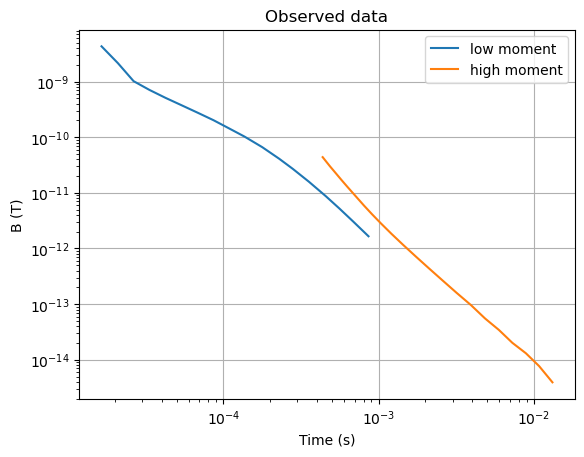

In [14]:
# plot data for single station (1999)
plt.loglog(LM_times, station_lm_data, label="low moment")
plt.loglog(HM_times, station_hm_data, label="high moment")
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('B (T)')
plt.title('Observed data')
plt.legend()
plt.show()

### Setting up survey

In [16]:
LM_waveform_excel = "../../LM_waveform.csv"
HM_waveform_excel = "../../HM_waveform.csv"
LM_waveform_csv = pd.read_csv(LM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_waveform_csv = pd.read_csv(HM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [17]:
# extract the time and form from waveform_csv 
LM_wave_time = LM_waveform_csv["Time (s)"]
LM_wave_form = LM_waveform_csv["Amplitude"]
HM_wave_time = HM_waveform_csv["Time (s)"]
HM_wave_form = HM_waveform_csv["Amplitude"]

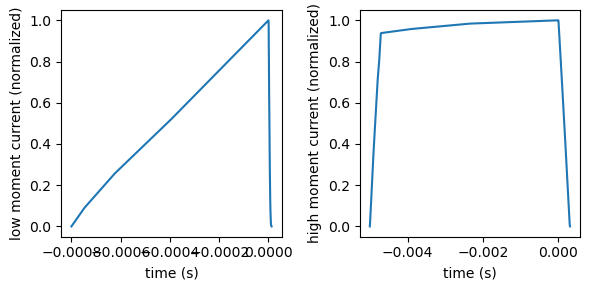

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].plot(LM_wave_time, LM_wave_form)
ax[0].set_ylabel("low moment current (normalized)")
ax[0].set_xlabel("time (s)")

ax[1].plot(HM_wave_time, HM_wave_form)
ax[1].set_ylabel("high moment current (normalized)")
ax[1].set_xlabel("time (s)")

plt.tight_layout()

In [19]:
# shape of the transmitter, and the offset of the receiver coil.
tx_shape = np.array([
#      -13.46,   0.  ,  -2.])  
    [-12.64,  -2.13,   0.  ],
    [ -6.15,  -8.59,   0.  ],
    [  5.74,  -8.59,   0.  ],
    [ 11.13,  -3.19,   0.  ],
    [ 11.13,   3.19,   0.  ],
    [  5.74,   8.59,   0.  ],
    [ -6.15,   8.59,   0.  ],
    [-12.64,   2.13,   0.  ],
    [-12.64,  -2.13,   0.  ]])
rx_offset = np.array([-13.46,   0.  ,  -2.  ]) # from data processing report

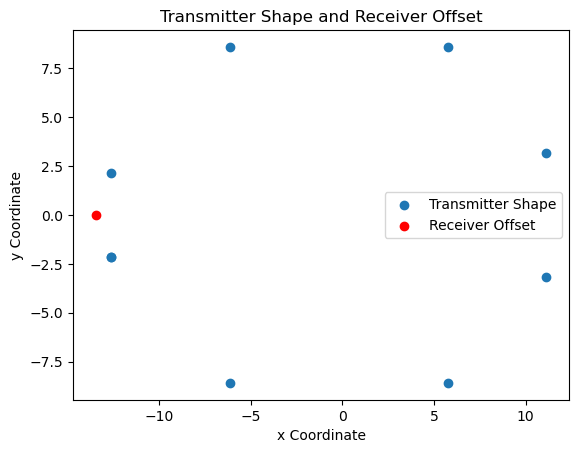

In [20]:
# Extract x and y coordinates for transmitter shape
tx_x = [point[0] for point in tx_shape]
tx_y = [point[1] for point in tx_shape]

# Scatter plot for transmitter shape
plt.scatter(tx_x, tx_y, label='Transmitter Shape')

# Scatter plot for receiver offset
plt.scatter(rx_offset[0], rx_offset[1], label='Receiver Offset', color='red')

# Add labels and legend
plt.xlabel('x Coordinate')
plt.ylabel('y Coordinate')
plt.title('Transmitter Shape and Receiver Offset')
plt.legend()

# Show the plot
plt.show()

In [21]:
# add UTM coordinates to transmitter shape and the receiver offset
# tx_loc = tx_shape + [311527.56, 6783344.30, station["GPS_Alt"].iloc[0]]
tx_loc = tx_shape + [station["Easting"].iloc[0], station["Northing"].iloc[0],# station["GPS_Alt"].iloc[0]]
                      #station["GPS_Alt"].iloc[0]-station["DTM_AHD"].iloc[0]]
                      #station["Frame_Height"].iloc[0]-station["DTM_AHD"].iloc[0]]
                      station["Frame_Height"].iloc[0]]
rx_loc = rx_offset + [station["Easting"].iloc[0], station["Northing"].iloc[0],# station["GPS_Alt"].iloc[0]]  
                      #station["GPS_Alt"].iloc[0]-station["DTM_AHD"].iloc[0]]
                      #station["Frame_Height"].iloc[0]-station["DTM_AHD"].iloc[0]]
                      station["Frame_Height"].iloc[0]]
tx_area=342.0 # from data processing report

In [22]:
rx_loc

array([3.11484470e+05, 6.78334675e+06, 3.85800000e+01])

In [23]:
station["GPS_Alt"]

6001    159.59
Name: GPS_Alt, dtype: float64

In [24]:
station["DTM_AHD"]

6001    144.94
Name: DTM_AHD, dtype: float64

In [25]:
station["Frame_Height"]

6001    40.58
Name: Frame_Height, dtype: float64

In [26]:
# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, LM_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(LM_wave_time, LM_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

In [27]:
src_lm

In [28]:
# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, HM_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(HM_wave_time, HM_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

In [29]:
srv = tdem.Survey([src_lm, src_hm])
srv_lm = tdem.Survey(src_lm)
srv_hm = tdem.Survey(src_hm)

In [30]:
src_lm

In [31]:
# simple forward simulation
thicknesses = [] #[1]
conductivities = [1e-1]

In [32]:
sim = tdem.Simulation1DLayered(srv, sigma=conductivities, thicknesses=thicknesses)

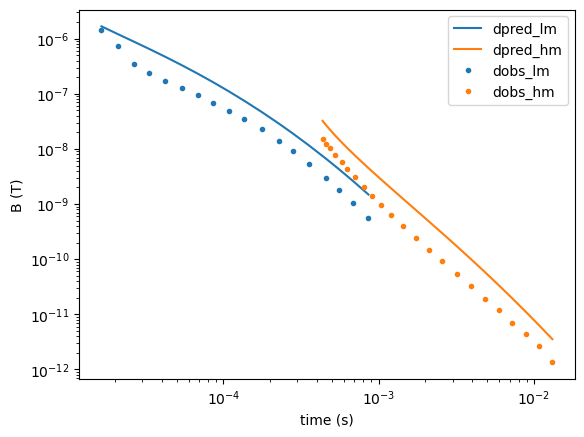

In [33]:
# sim.thicknesses = [5]
# sim.sigma = [3E-1]
pre = -sim.dpred(None)
pre_lm = pre[:18]
pre_hm = pre[18:]

plt.loglog(LM_times, pre_lm, label="dpred_lm")
plt.loglog(HM_times, pre_hm, label="dpred_hm")
plt.loglog(LM_times, station_lm_data*tx_area, color='C0', marker='.', linestyle='', label="dobs_lm")
plt.loglog(HM_times, station_hm_data*tx_area, color='C1', marker='.', linestyle='', label="dobs_hm")
plt.xlabel("time (s)")
plt.ylabel("B (T)")
plt.legend()
plt.show()

# Set up inversion for single station

In [35]:
# map
exp_map = maps.ExpMap()
exp_map * np.array([-5])

array([0.00673795])

In [36]:
# observed data (normalised) & relative errors 
dobs = -tx_area * np.r_[station_lm_data, station_hm_data]
rel_err = np.r_[station_lm_std, station_hm_std]

# Convert 'dobs' to a proper numeric array
dobs = np.array(dobs, dtype=np.float64)  # Force float64 conversion

# Ensure no NaN or infinite values
dobs = np.nan_to_num(dobs, nan=1e-10, posinf=1e-10, neginf=-1e-10)

# Convert 'rel_err' to a proper numeric array
rel_err = np.array(rel_err, dtype=np.float64)  # Ensure float64 type

# Handle NaN or invalid values
rel_err = np.nan_to_num(rel_err, nan=1e-10, posinf=1e-10, neginf=1e-10)

# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

# rel_err = np.full(41, 0.05)

# data_container = data.Data(srv, dobs=dobs, relative_error=uncertainties) # method 2 to obtain data_object
data_container = data.Data(srv, dobs=dobs, relative_error=rel_err) # method 1 to obtain data_object


### Parametric Halfspace inversion

In [38]:
sim_inv1 = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)

In [39]:
phi_d_1 = L2DataMisfit(data=data_container, simulation=sim_inv1)

In [40]:
# we can evaluate this function.
m_0 = np.log(1E-2)  # sigma = 1E-2 S/m

phi_d_1(m_0)

22038417.280079924

In [41]:
minimizer = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)
# Here, Inexact means we are going to use CG to solve for the step direction.

In [42]:
empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
# note we needed to pass a mesh that had a single cell
# in it because our model has 1 value.

In [43]:
inv_prob_1 = inverse_problem.BaseInvProblem(
    phi_d_1, reg=empty_reg, opt=minimizer, beta=0.0
)

# sets up, phi_d + 0 * phi_m, meaning the minimizer is only going to act on the data misfit term.

In [44]:
inv1 = inversion.BaseInversion(inv_prob_1, [])

In [45]:
# Run inversion
recovered_model = inv1.run(m_0)


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  2.20e+07  0.00e+00  2.20e+07    1.42e+07      0              
   1  0.00e+00  4.35e+06  1.12e+00  4.35e+06    1.38e+07      1              
   2  0.00e+00  1.86e+06  1.94e+00  1.86e+06    1.48e+06      0   Skip BFGS  
   3  0.00e+00  1.85e+06  1.88e+00  1.85e+06    8.72e+04      0              
   4  0.00e+00  1.85e+06  1.88e+00  1.85e+06    4.63e+03      0   Skip BFGS  
   5  0

In [46]:
# What was our recovered best fitting halfspace?
sim_inv1.sigmaMap * recovered_model

array([0.03940833])

In [47]:
# This function returns a data object
# (so we can easily index it with receivers for plotting)
data_pre = sim_inv1.make_synthetic_data(recovered_model)

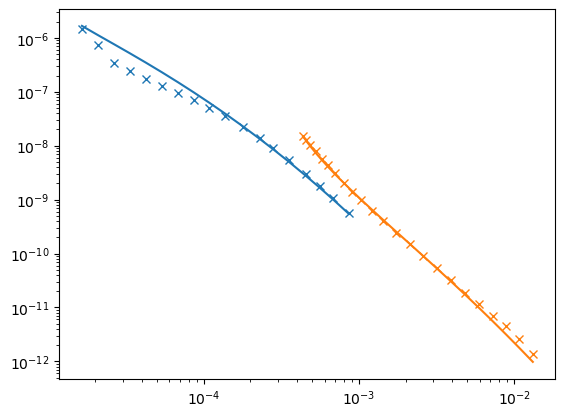

In [48]:
def plot_data(data_obj):
    plt.loglog(LM_times, -data_obj[src_lm, rx_lm])
    plt.loglog(HM_times, -data_obj[src_hm, rx_hm])
    
    plt.loglog(
        LM_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
    )
    plt.loglog(
        HM_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
    )
    
plot_data(data_pre)

### Multiple layers

In [50]:
n_layers = 2
wire_map = maps.Wires(('sigma',n_layers), ('thicknesses', n_layers-1))

In [51]:
sigma_map = exp_map * wire_map.sigma
thick_map = wire_map.thicknesses # exp_map * wire_map.thicknesses # delete exp_map

In [52]:
# let's use the best fitting half-space as our initial model
m_sigma_0_2 = np.full(n_layers, recovered_model[0])  # Already in log-space
m_h_0_2 = np.log(np.full(n_layers-1, 10))
m_0_2 = np.r_[m_sigma_0_2, m_h_0_2]

sim_inv2 = tdem.Simulation1DLayered(srv, sigmaMap=sigma_map, thicknessesMap=thick_map)

In [53]:
sim_inv2.model = m_0_2
sim_inv2.sigma

array([0.03940833, 0.03940833])

In [54]:
phi_d_2 = L2DataMisfit(data=data_container, simulation=sim_inv2)

# create all of the same components of the inversion problem as before
minimizer2 = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# again create a reg that has the same input size as the model vector, and then turn it off by setting `beta=0`
empty_reg = regularization.Smallness(discretize.TensorMesh([len(m_0_2)]))
inv_prob_2 = inverse_problem.BaseInvProblem(
    phi_d_2, reg=empty_reg, opt=minimizer2, beta=0.0
)

In [55]:
inv2 = inversion.BaseInversion(inv_prob_2, [])

# Run inversion
recovered_model_2 = inv2.run(m_0_2)


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  1.85e+06  0.00e+00  1.85e+06    1.17e+06      0              
   1  0.00e+00  1.59e+06  2.45e+00  1.59e+06    7.78e+06      0              
   2  0.00e+00  6.68e+05  1.07e+01  6.68e+05    1.42e+05      0              
   3  0.00e+00  6.67e+05  1.02e+01  6.67e+05    1.64e+05      9   Skip BFGS  
   4  0.00e+00  6.67e+05  9.86e+00  6.67e+05    2.24e+05      8   Skip BFGS  
   5  0

In [56]:
data_pre_2 = sim_inv2.make_synthetic_data(recovered_model_2)
sim_inv2.sigma, sim_inv2.thicknesses

(array([0.0223303 , 0.04958368]), array([14.1435466]))

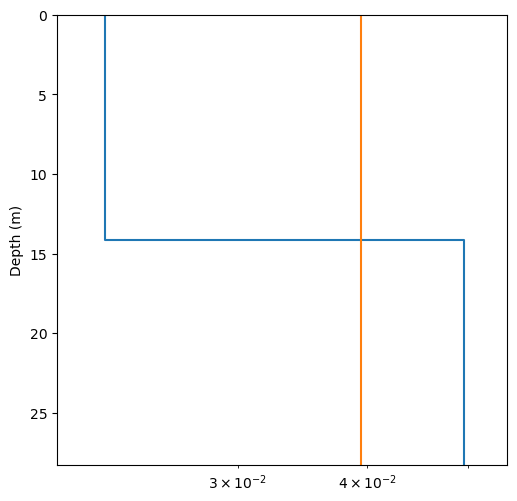

In [57]:
ax = plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma)
ax.axvline(sim_inv1.sigma, color='C1')
#ax.set_ylim([50, 0])
#ax.set_xlim([1E-2, 1E0]);

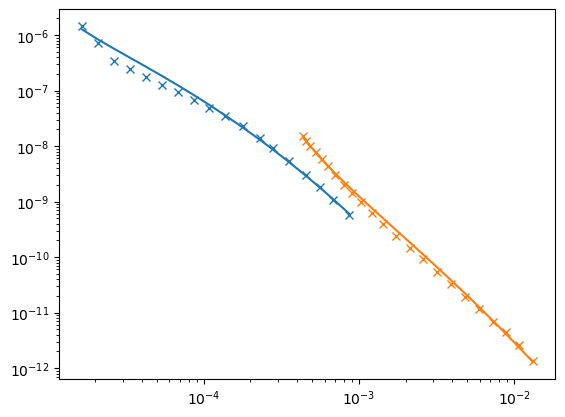

In [58]:
plot_data(data_pre_2)

### Regularized inversion

In [60]:
# (start_size, number_of_cells, expansion_factor)
h = [1, (1.0, 63, 1.05)]
mesh = discretize.TensorMesh([h,])
mesh

TensorMesh: 64 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64          0.00        434.09      1.00     21.62    1.05

In [61]:
sim_reg = tdem.Simulation1DLayered(srv, sigmaMap=exp_map, thicknesses=mesh.h[0][:-1])

phi_d_reg = L2DataMisfit(data=data_container, simulation=sim_reg)

# This class creates a function that measures the smallness
# and the smoothness of the model.
reg = regularization.WeightedLeastSquares(mesh)

In [62]:
m_0_reg = np.full(mesh.n_cells, recovered_model[0])

In [63]:
# create all of the same components of the inversion problem as before
minimizer_reg = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

inv_prob_3 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg #, beta=5 # change beta !
)

In [64]:
# update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
#starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
#target_misfit = directives.TargetMisfit(chifact=1.0)

#directives_list_L2 = [starting_beta, beta_schedule, target_misfit]

In [65]:
save_dict = directives.SaveOutputDictEveryIteration()

In [66]:
inv3 = inversion.BaseInversion(inv_prob_3, [save_dict, beta_schedule])

# Run inversion
recovered_model_3 = inv3.run(m_0_reg)


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.85e+06  0.00e+00  1.85e+06    1.17e+06      0              
   1  1.00e+00  1.17e+06  9.58e+00  1.17e+06    1.10e+06      2              
   2  1.00e+00  7.98e+05  2.99e+01  7.98e+05    1.22e+06      2   Skip BFGS  
   3  5.00e-01  6.23e+05  5.72e+0

(0.001, 100000.0)

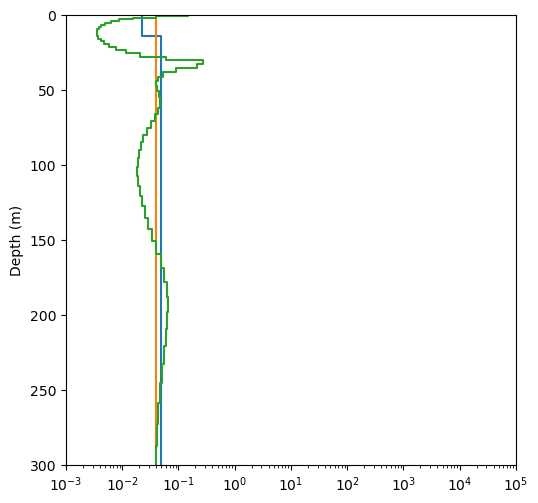

In [67]:
data_pre_3 = sim_reg.make_synthetic_data(recovered_model_3)
ax = plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma)
ax.axvline(sim_inv1.sigma, color='C1')
plot_1d_layer_model(sim_reg.thicknesses, sim_reg.sigma, ax=ax, color='C2')
ax.set_ylim([300, 0])
ax.set_xlim([1E-3, 1E5])

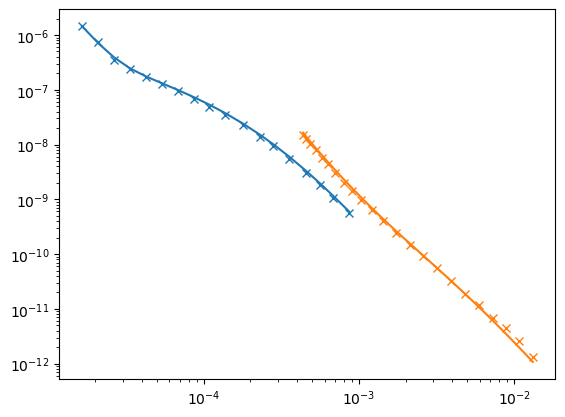

In [68]:
plot_data(data_pre_3)

In [78]:
n_iter = save_dict.opt.iter
phi_ds = [save_dict.outDict[i]['phi_d'] for i in range(1, n_iter)]
phi_ms = [save_dict.outDict[i]['phi_m'] for i in range(1, n_iter)]
betas =  [save_dict.outDict[i]['beta'] for i in range(1, n_iter)]

In [80]:
phi_ms

[92.33340505676081,
 263.4758717825307,
 316.0522878651238,
 373.30211796458855,
 430.0708712394792,
 482.4916514705579,
 510.6157842820527,
 538.5533291972099,
 564.670456053634]

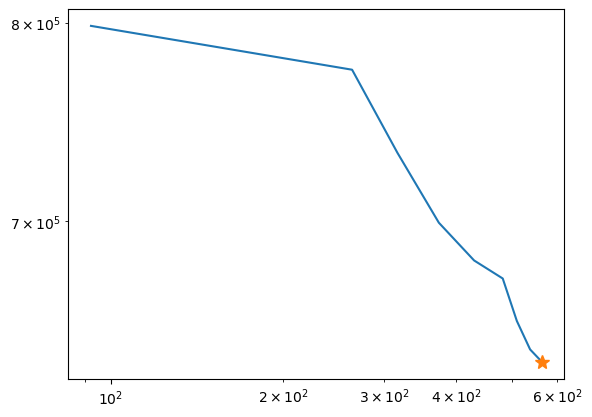

In [82]:
# this is an L-curvey plot
plt.loglog(phi_ms, phi_ds)
plt.loglog(phi_ms[8], phi_ds[8], marker='*', markersize=10)

In [127]:
sim_reg

In [129]:
sim_reg.sigma, sim_reg.thicknesses

(array([0.1486068 , 0.04046164, 0.01568814, 0.00885259, 0.00622579,
        0.00494578, 0.00423222, 0.00382054, 0.0036047 , 0.00353702,
        0.00359782, 0.00379038, 0.00414913, 0.00475822, 0.00579806,
        0.00768607, 0.01150925, 0.02115913, 0.06069311, 0.27389403,
        0.2124937 , 0.09120065, 0.05428227, 0.0427134 , 0.03996097,
        0.04142083, 0.04486584, 0.04786078, 0.047869  , 0.04416484,
        0.03831252, 0.03234524, 0.02740358, 0.02374914, 0.02124426,
        0.019675  , 0.0188717 , 0.0187336 , 0.01922575, 0.02037401,
        0.02226442, 0.02504404, 0.02891256, 0.03407798, 0.04062648,
        0.04825335, 0.05592377, 0.06186888, 0.06443072, 0.06327369,
        0.05953734, 0.05481723, 0.05027485, 0.04646246, 0.04352029,
        0.04138958, 0.03993998, 0.03902815, 0.03852046, 0.03830065,
        0.03827214, 0.03835854, 0.03849855, 0.03670762]),
 array([ 1.        ,  1.05      ,  1.1025    ,  1.157625  ,  1.21550625,
         1.27628156,  1.34009564,  1.40710042,  1.477

In [ ]:
beta_cooler = directives.BetaSchedule(coolingFactor=5, coolingRate=2)

In [ ]:
save_dict = directives.SaveOutputDictEveryIteration()

In [ ]:
# create all of the same components of the inversion problem as before
minimizer_reg = opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=100, tolCG=1e-5
)

inv_prob_4 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg, beta=10000
)

inv4 = inversion.BaseInversion(inv_prob_4, [save_dict, beta_cooler])

# Run inversion
recovered_model_4 = inv4.run(m_0_reg)

In [ ]:
n_iter = save_dict.opt.iter
phi_ds = [save_dict.outDict[i]['phi_d'] for i in range(1, n_iter)]
phi_ms = [save_dict.outDict[i]['phi_m'] for i in range(1, n_iter)]
betas =  [save_dict.outDict[i]['beta'] for i in range(1, n_iter)]

In [ ]:

# this is an L-curvey plot
plt.loglog(phi_ms, phi_ds)
plt.loglog(phi_ms[14], phi_ds[14], marker='*', markersize=10)

In [ ]:
m_final = save_dict.outDict[14]['m']
d_final = sim_reg.make_synthetic_data(m_final)
ax = plot_1d_layer_model(sim_reg.thicknesses, exp_map * m_final)
plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma, ax=ax)
ax.set_ylim([300, 0])
ax.set_xlim([1E-3, 1E0])

In [ ]:
plot_data(d_final)